In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from datetime import datetime
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

#### Importing teflon data

In [2]:
Directory = '20220210'
Date = '2022-02-10'

In [3]:
File = '/gpfs/loomis/project/fas/david_moore/aj487/Data_WL110/Outgassing_Setup/{}/RGAScan_{}.h5'.format(Directory, Date)
rga_scans = np.array(pd.read_hdf(File, key='rga/rga'))
rga_timestamps = np.array(pd.read_hdf(File, key='rga/timestamp'))
amu = np.arange(1,100.01,0.1)
delta_t = np.array([datetime.strptime(x, '%Y%m%d%H%M%S') for x in rga_timestamps])

In [4]:
TempFile = '/gpfs/loomis/project/fas/david_moore/aj487/Data_WL110/Outgassing_Setup/{}/Temps_{}.h5'.format(Directory, Date)
temp = np.array(pd.read_hdf(TempFile, key='omega/omega'))
temp_timestamps = np.array(pd.read_hdf(TempFile, key='omega/timestamp'))
tempdelta_t = np.array([datetime.strptime(x, '%Y%m%d%H%M%S') for x in temp_timestamps])

In [5]:
PressFile = '/gpfs/loomis/project/fas/david_moore/aj487/Data_WL110/Outgassing_Setup/{}/Pressure_{}.h5'.format(Directory, Date)
press = np.array(pd.read_hdf(PressFile, key='ed/ed'))
press_timestamps = np.array(pd.read_hdf(PressFile, key='ed/timestamp'))
pressdelta_t = np.array([datetime.strptime(x, '%Y%m%d%H%M%S') for x in press_timestamps])
# pressdelta_t = np.array([(x-pressdelta_t[0]).total_seconds() for x in pressdelta_t])

In [6]:
TECFile = glob.glob('/gpfs/loomis/project/fas/david_moore/aj487/Data_WL110/Outgassing_Setup/{}/TEC_*.h5'.format(Directory))
TECFile.sort()
tec = np.empty(4, dtype='object')
tec_timestamps = np.empty(4, dtype='object')
for i, file in enumerate(TECFile):
    tec[i] =  np.array(pd.read_hdf(file, key='tec/tec'))
    tec_timestamps[i] = np.array(pd.read_hdf(file, key='tec/timestamp'))
tec = np.vstack(tec)
tec_timestamps = np.concatenate((tec_timestamps[0], tec_timestamps[1], tec_timestamps[2], tec_timestamps[3]))
tecdelta_t = np.array([datetime.strptime(x, '%Y%m%d%H%M%S') for x in tec_timestamps])
# tecdelta_t = np.array([(x-tecdelta_t[0]).total_seconds() for x in tecdelta_t])

In [7]:
# picking the temperature and time from the thermocouples that best matches each time the rga scan was made
rga_temp_ind = np.zeros(len(rga_scans), dtype='int64')
for i, t in enumerate(delta_t):
    if (len(np.where(tempdelta_t == t)[0]) > 0):
        rga_temp_ind[i] = np.where(tempdelta_t == t)[0][0]
    else:
        rga_temp_ind[i] = np.argmin(abs(tempdelta_t - t))
temp = temp[rga_temp_ind]
temp1 = temp[:,0]
temp2 = temp[:,1]
meantemp = np.mean(np.array([temp[:,0], temp[:,1]]), 0)
tempdelta_t = tempdelta_t[rga_temp_ind]

In [8]:
# resetting the start time to be the time of the first rga scan
time0 = delta_t[0]
delta_t = np.array([(x-time0).total_seconds() for x in delta_t])
tempdelta_t = np.array([(x-time0).total_seconds() for x in tempdelta_t])
tecdelta_t = np.array([(x-time0).total_seconds() for x in tecdelta_t])

#### Importing background data

In [14]:
Directory_b = '20220204'
Date_b = '2022-02-04'

In [15]:
File_b = '/gpfs/loomis/project/fas/david_moore/aj487/Data_WL110/Outgassing_Setup/{}/RGAScan_{}.h5'.format(Directory_b, Date_b)
rga_scans_b = np.array(pd.read_hdf(File_b, key='rga/rga'))
rga_timestamps_b = np.array(pd.read_hdf(File_b, key='rga/timestamp'))
delta_t_b = np.array([datetime.strptime(x, '%Y%m%d%H%M%S') for x in rga_timestamps_b])

In [16]:
TempFile_b = '/gpfs/loomis/project/fas/david_moore/aj487/Data_WL110/Outgassing_Setup/{}/Temps_{}.h5'.format(Directory_b, Date_b)
temp_b = np.array(pd.read_hdf(TempFile_b, key='omega/omega'))
temp_timestamps_b = np.array(pd.read_hdf(TempFile_b, key='omega/timestamp'))
tempdelta_t_b = np.array([datetime.strptime(x, '%Y%m%d%H%M%S') for x in temp_timestamps_b])

In [17]:
PressFile_b = '/gpfs/loomis/project/fas/david_moore/aj487/Data_WL110/Outgassing_Setup/{}/Pressure_{}.h5'.format(Directory_b, Date_b)
press_b = np.array(pd.read_hdf(PressFile_b, key='ed/ed'))
press_timestamps_b = np.array(pd.read_hdf(PressFile_b, key='ed/timestamp'))
pressdelta_t_b = np.array([datetime.strptime(x, '%Y%m%d%H%M%S') for x in press_timestamps_b])

In [19]:
TECFile_b = '/gpfs/loomis/project/fas/david_moore/aj487/Data_WL110/Outgassing_Setup/{}/TEC_{}.h5'.format(Directory_b, Date_b)
tec_b = np.array(pd.read_hdf(TECFile_b, key='tec/tec'))
tec_timestamps_b = np.array(pd.read_hdf(TECFile_b, key='tec/timestamp'))
tecdelta_t_b = np.array([datetime.strptime(x, '%Y%m%d%H%M%S') for x in tec_timestamps_b])

In [20]:
# picking the temperature and time from the thermocouples that best matches each time the rga scan was made 
# (background version)
rga_temp_ind_b = np.zeros(len(rga_scans_b), dtype='int64')
for i, t in enumerate(delta_t_b):
    if (len(np.where(tempdelta_t_b == t)[0]) > 0):
        rga_temp_ind_b[i] = np.where(tempdelta_t_b == t)[0][0]
    else:
        rga_temp_ind_b[i] = np.argmin(abs(tempdelta_t_b - t))
temp_b = temp_b[rga_temp_ind_b]
temp1_b = temp_b[:,0]
temp2_b = temp_b[:,1]
meantemp_b = np.mean(np.array([temp_b[:,0], temp_b[:,1]]), 0)
tempdelta_t_b = tempdelta_t_b[rga_temp_ind_b]

In [21]:
# resetting the start time to be the time of the first rga scan
time0_b = delta_t_b[0]
delta_t_b = np.array([(x-time0_b).total_seconds() for x in delta_t_b])
tempdelta_t_b = np.array([(x-time0_b).total_seconds() for x in tempdelta_t_b])
tecdelta_t_b = np.array([(x-time0_b).total_seconds() for x in tecdelta_t_b])

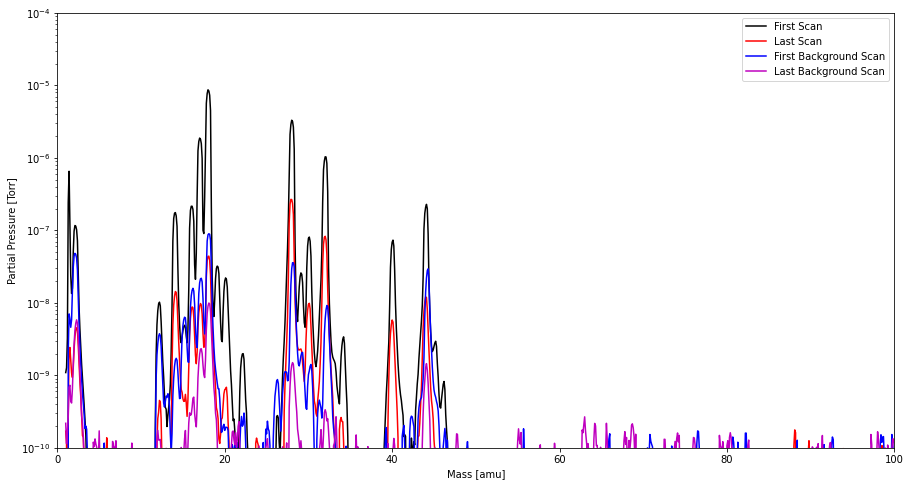

In [22]:
plt.figure(figsize=(15,8))
plt.xlabel('Mass [amu]')
plt.ylabel('Partial Pressure [Torr]')
plt.xlim(0,100)
plt.ylim(1e-10,1e-4)
total_p = []
for x in rga_scans: 
    total_p.append(np.sum(x))
    # plt.plot(amu, x, color='k', lw=1)
plt.plot(amu, rga_scans[0], color='k', alpha=1, label='First Scan')
plt.plot(amu, rga_scans[-1], color='r', alpha=1, label='Last Scan')
plt.plot(amu, rga_scans_b[0], color='b', alpha=1, label='First Background Scan')
plt.plot(amu, rga_scans_b[-1], color='m', alpha=1, label='Last Background Scan')
plt.legend(loc='upper right')

plt.yscale('log')
plt.show()

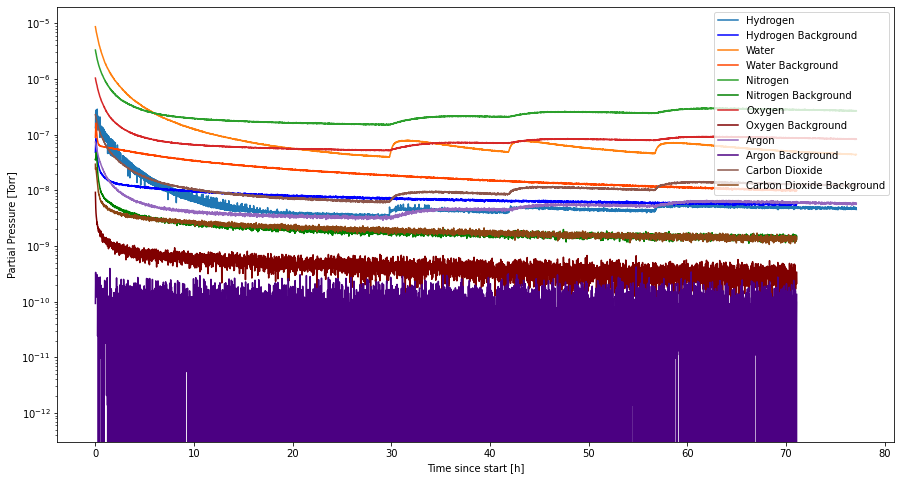

In [31]:
gases = [2,18,28,32,40,44]
labels = ['Hydrogen','Water','Nitrogen','Oxygen','Argon','Carbon Dioxide']
colors = ['b', 'orangered', 'g', 'maroon', 'indigo', 'saddlebrown']

plt.figure(figsize=(15,8))
# plt.xlim(0,np.max(delta_t/3600.0))
# plt.ylim(1e-10,1e-4)
plt.xlabel('Time since start [h]')
plt.ylabel('Partial Pressure [Torr]')

for i,gas in enumerate(gases):
    cut = np.where((amu<gas+0.5) & (amu>gas-0.5))
    pp = [np.max(x[cut]) for x in rga_scans]
    pp_b = [np.max(x[cut]) for x in rga_scans_b]
    plt.plot(delta_t/3600.0, pp, label=labels[i])
    plt.plot(delta_t_b/3600.0, pp_b, label='{} Background'.format(labels[i]), color = colors[i])

plt.legend(loc='upper right')
plt.yscale('log')
plt.show()

In [33]:
def pick_gas(rga_scan, masses, elements):
    '''Returning a dictionary that includes the partial pressures from a certain gas'''
    rga_indiv_gas = {}
    for mass, element in zip(masses, elements):
        mask = np.where((amu<mass+0.5) & (amu>mass-0.5))
        rga_indiv_gas[element] = [np.max(rga[mask]) for rga in rga_scan]
    return rga_indiv_gas

In [36]:
o2pp = pick_gas(rga_scans, [32], ['Oxygen'])['Oxygen']
o2pp_b = pick_gas(rga_scans_b, [32], ['Oxygen'])['Oxygen']

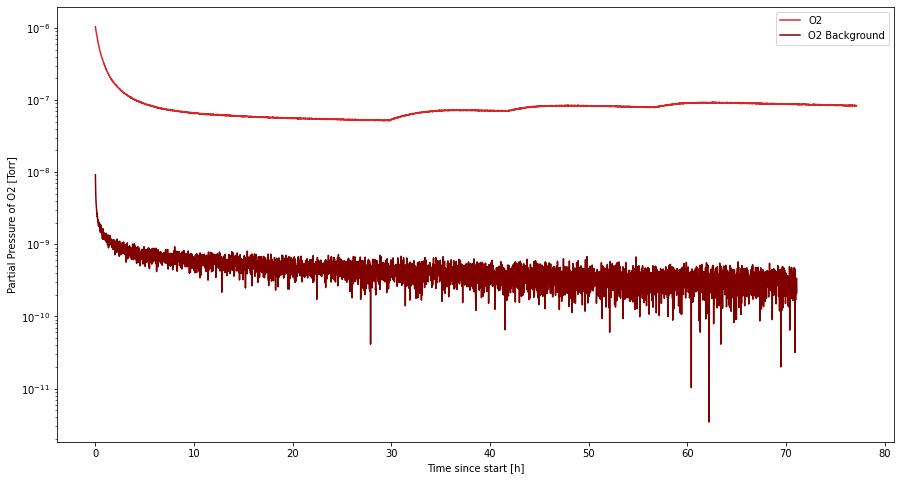

In [40]:
plt.figure(figsize=(15,8))
plt.plot(delta_t/3600.0, o2pp, label='O2', color='C3')
plt.plot(delta_t_b/3600, o2pp_b, label='O2 Background', color='maroon')
plt.yscale('log')
plt.xlabel('Time since start [h]')
plt.ylabel('Partial Pressure of O2 [Torr]')
plt.legend()
plt.show()